# CORE Paper Figures
This Jupyter notebook generates all figures and quantiative results for the paper "CORE-Bench: Fostering the Credibility of Published Research Through a Computational Reproducibility Benchmark".

# Downloading the data

In [1]:
import urllib.request
import tarfile
import os

# URLs to download
urls = [
    "https://corebench.cs.princeton.edu/agent_logs.tar.gz",
    "https://corebench.cs.princeton.edu/agent_results.tar.gz"
]

# Function to download and extract .tar.gz files
def download_and_extract(url):
    file_name = url.split("/")[-1]
    
    # Download the file
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded {file_name}")
    
    # Extract the file
    with tarfile.open(file_name, "r:gz") as tar:
        tar.extractall()
    print(f"Extracted {file_name}")

# Download and extract each file
for url in urls:
    if not os.path.exists(url.split("/")[-1]):
        download_and_extract(url)

# Utility Functions

In [1]:
"""
Evaluates a run of the model on the benchmark.
"""
import json
import os
import numpy as np
from collections import OrderedDict, defaultdict
import seaborn as sns
from scipy.stats import t
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import pandas as pd

color_palette = sns.color_palette("Dark2", 10)

In [2]:
# This class contains all information about a task, compiling it from three different sources:
# the results directory, the logs directory, and the dataset directory.
# The results directory contains the report.json file, which contains the agent's submitted results of the task.
# The logs directory contains the log file, which contains the cost, time, and agent memory of the experiment.
# The dataset directory contains the dataset file, which contains the correct answers to the task.
class Task:
    def __init__(self, report_json, log_json, exp_id, dataset_json, cost_limit = None):
        # Get the task success directly from the result file
        self.report_json = report_json
        self.task_name = exp_id.split("_", 1)[-1]
        self.log_json = log_json

        self.capsule_id = report_json['capsule_id']
        self.field = report_json['field']
        self.language = report_json['language']
        self.llm_summary = report_json['llm_summary'] if 'llm_summary' in report_json else None
        
        self.correct_written = report_json['correct_written_answers']
        self.correct_vision = report_json['correct_vision_answers']
        self.total_written = report_json['total_written_questions']
        self.total_vision = report_json['total_vision_questions']

        self.written_success = report_json['correct_written_answers'] == report_json['total_written_questions']
        self.vision_success = report_json['correct_vision_answers'] == report_json['total_vision_questions']
        self.success = self.written_success and self.vision_success
        self.path_success = report_json['result_paths_success']
        self.any_paths = len(report_json['result_paths']) > 0

        # Determine if all questions were attempted
        self.attempted = all([key in self.report_json["result_report"] for key in dataset_json[self.capsule_id]["results"][0]])

        # Load the log file to get cost and time of experiment
        if self.log_json is not None:
            self.cost = self.log_json['cost'] if 'cost' in self.log_json else None
            self.time = self.log_json['time'] if 'time' in self.log_json else None
            self.model = self.log_json['model'] if 'model' in self.log_json else None
            self.exception = self.log_json['exception'] if 'exception' in self.log_json else None
        else:
            self.cost = None
            self.time = None
            self.model = None
            self.exception = None

        # Fail the task if it exceeds the cost limit
        if cost_limit is not None and self.cost > cost_limit:
            self.success = False
            
    def __str__(self):
        return str(self.__dict__)
    
    def __repr__(self):
        return str(self.__dict__)

In [3]:
def categorize_by_level(tasks):
    categorized_tasks = OrderedDict()
    task_names = ['codeocean_easy', 'codeocean_medium', 'codeocean_hard']
    for task_name in task_names:
        categorized_tasks[task_name] = []
    for task in tasks:
        categorized_tasks[task.task_name].append(task)
    return categorized_tasks

def categorize_by_id(tasks):
    categorized_tasks = defaultdict(list)
    for task in tasks:
        categorized_tasks[task.capsule_id].append(task)
    return categorized_tasks

In [4]:
def load_tasks(*results_folders, dataset_dir = "dataset/core_test.json", skip_tasks = []):
    tasks_from_json = []
    for results_folder in results_folders:
        tasks_from_json.extend(load_tasks_from_json(results_folder, dataset_dir, skip_tasks))
    return {task_level_name: categorize_by_id(task_level) for task_level_name, task_level in categorize_by_level(tasks_from_json).items()}

def load_tasks_from_json(results_folder, dataset_dir, skip_tasks = []):
    results_files = [os.path.join(results_folder, f) for f in os.listdir(results_folder)]
    tasks = []

    dataset_json = json.load(open(dataset_dir))
    dataset_json = {task['capsule_id']: task for task in dataset_json}

    for results_file in results_files:
        if not results_file.endswith('.json'):
            continue
        if results_file in skip_tasks:
            continue
        with open(results_file, 'r') as f:
            json_file = json.load(f)
            if 'capsule_results' not in json_file:
                continue
            result_json = json_file['capsule_results']
            for task_json in result_json:
                log_file = results_file.replace('results', 'logs').replace('.json', f"/{task_json['capsule_id']}.log")
                try:
                    with open(log_file, 'r') as f:
                        log_json = json.load(f)
                except:
                    log_json = None
                tasks.append(
                    Task(task_json, 
                         log_json, 
                         os.path.basename(results_file).replace('.json', ''),
                         dataset_json
                        )
                )
    
    return tasks

In [5]:
def plot_success_by_level(
    tasks_by_model: list,
    legend_names: list,
    pass_at: int,
    task_names: OrderedDict = None,
    model_name: str = '',
    verbose: bool = False
):
    assert len(legend_names) == len(tasks_by_model)

    # Compute success rates by model (same logic as original)
    success_rates_by_model = [
        [
            sum(
                any(task.success for task in tasks[task_id][:pass_at])
                for task_id in tasks
            ) / len(tasks)
            for tasks in model_tasks.values()
        ]
        for model_tasks in tasks_by_model
    ]
    task_label = (
        tasks_by_model[0].keys()
        if task_names is None
        else [task_names[x] for x in tasks_by_model[0].keys()]
    )

    # Set Seaborn style
    sns.set(style='whitegrid', context='paper')

    # Define figure size and DPI
    plt.figure(figsize=(5, 3), dpi=300)

    # Convert task labels to list if they are not already
    if not isinstance(task_label, list):
        task_label = list(task_label)

    # Define bar width and positions
    n_tasks = len(task_label)
    n_models = len(tasks_by_model)
    bar_width = 0.35
    index = np.arange(n_tasks)

    # Plot success rates by model
    for i, legend_name in enumerate(legend_names):
        hatch_pattern = '//' if i == 1 else None  # Apply hatching to the second model

        plt.bar(
            index + i * bar_width,
            success_rates_by_model[i],
            width=bar_width,
            label=legend_name,
            color=color_palette[i % len(color_palette)],
            hatch=hatch_pattern  # Add hatching pattern
        )
        if verbose:
            print(f'{legend_name} Success Rate by Task Level (pass@{pass_at}):')
            for task_id, task_name in enumerate(task_label):
                print(f'\t{task_name}: {round(success_rates_by_model[i][task_id], 4)}')

    # Adjust x-axis
    plt.xlabel('Task Level', fontsize=9)
    plt.xticks(index + bar_width / 2 * (n_models - 1), task_label, fontsize=8)
    plt.ylabel('Success Rate', fontsize=9)
    plt.ylim(0, 1)
    plt.yticks(fontsize=8)

    # Add title and legend
    plt.title(f'{model_name} Success Rate by Task Level', fontsize=10)
    plt.legend(fontsize=7, frameon=True, framealpha=0.9)

    # Add grid lines
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, axis='y')

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [6]:
def plot_success_pass_at(
    tasks_by_model: list,
    legend_names: list,
    pass_at: int,
    task_names: dict = None,
    model_name: str = '',
    verbose: bool = False
):
    assert len(legend_names) == len(tasks_by_model)

    # Compute success rates for each pass_at
    success_rate_pass_at = []
    for k in range(1, pass_at + 1):
        success_rates_by_model = [
            [
                sum(
                    any(task.success for task in tasks[task_id][:k])
                    for task_id in tasks
                ) / len(tasks)
                for tasks in model_tasks.values()
            ]
            for model_tasks in tasks_by_model
        ]
        success_rate_pass_at.append(success_rates_by_model)

        if verbose:
            print(f'Pass@{k}: {success_rates_by_model}')
    
    # Prepare task labels
    if task_names is None:
        task_labels = list(tasks_by_model[0].keys())
    else:
        task_labels = [task_names[x] for x in tasks_by_model[0].keys()]

    # Set Seaborn style
    sns.set(style='whitegrid', context='paper')

    # Define figure size and DPI
    plt.figure(figsize=(5, 3), dpi=300)

    # Calculate total number of lines
    n_models = len(legend_names)
    n_tasks = len(task_labels)
    n_lines = n_models * n_tasks

    # Define line styles
    line_styles = ['-', '--', ':']  # Solid, dashed, and dotted

    # Plot success rates by model and task level
    line_idx = 0
    for i, legend_name in enumerate(legend_names):
        for task_id, task_name in enumerate(task_labels):
            # Extract success rates for current model and task
            success_rates = [
                success_rate_pass_at[k - 1][i][task_id] for k in range(1, pass_at + 1)
            ]
            plt.plot(
                range(1, pass_at + 1),
                success_rates,
                label=f'{legend_name} {task_name}',
                color=color_palette[line_idx % len(color_palette)],
                linestyle=line_styles[line_idx % len(line_styles)],  # Apply different line styles
                linewidth=1.5
            )
            line_idx += 1
            if verbose:
                print(f'{legend_name} {task_name} Success Rates: {success_rates}')

    # Customize plot aesthetics
    plt.xlabel('Pass@k', fontsize=9)
    plt.ylabel('Success Rate', fontsize=9)
    plt.xticks(range(1, pass_at + 1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim(0, 1)
    plt.title(f'{model_name} Pass@k Accuracy by Task Level', fontsize=10)
    plt.legend(fontsize=7, frameon=True, framealpha=0.9)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [7]:
def plot_success_pass_and(
    tasks_by_model: list,
    legend_names: list,
    pass_and: int,
    task_names: dict = None,
    model_name: str = '',
    verbose: bool = False
):
    assert len(legend_names) == len(tasks_by_model)

    # Compute success rates for each pass_and
    success_rate_pass_at = []
    for k in range(1, pass_and + 1):
        success_rates_by_model = [
            [
                sum(
                    all(task.success for task in tasks[task_id][:k])
                    for task_id in tasks
                ) / len(tasks)
                for tasks in model_tasks.values()
            ]
            for model_tasks in tasks_by_model
        ]
        success_rate_pass_at.append(success_rates_by_model)

        if verbose:
            print(f'Pass@{k}: {success_rates_by_model}')
    
    # Prepare task labels
    if task_names is None:
        task_labels = list(tasks_by_model[0].keys())
    else:
        task_labels = [task_names[x] for x in tasks_by_model[0].keys()]

    # Set Seaborn style
    sns.set(style='whitegrid', context='paper')

    # Define figure size and DPI
    plt.figure(figsize=(5, 3), dpi=300)

    # Calculate total number of lines
    n_models = len(legend_names)
    n_tasks = len(task_labels)
    n_lines = n_models * n_tasks

    # Define line styles
    line_styles = ['-', '--', ':']  # Solid, dashed, and dotted

    # Plot success rates by model and task level
    line_idx = 0
    for i, legend_name in enumerate(legend_names):
        for task_id, task_name in enumerate(task_labels):
            # Extract success rates for current model and task
            success_rates = [
                success_rate_pass_at[k - 1][i][task_id] for k in range(1, pass_and + 1)
            ]
            plt.plot(
                range(1, pass_and + 1),
                success_rates,
                label=f'{legend_name} {task_name}',
                color=color_palette[line_idx % len(color_palette)],
                linestyle=line_styles[line_idx % len(line_styles)],  # Apply line styles
                linewidth=1.5
            )
            line_idx += 1
            if verbose:
                print(f'{legend_name} {task_name} Success Rates: {success_rates}')

    # Customize plot aesthetics
    plt.xlabel('Pass^k', fontsize=9)
    plt.ylabel('Success Rate', fontsize=9)
    plt.xticks(range(1, pass_and + 1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim(0, 1)
    plt.title(f'{model_name} Pass^k Accuracy by Task Level', fontsize=10)
    plt.legend(fontsize=7, frameon=True, framealpha=0.9)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [8]:
def plot_accuracy_vs_cost(tasks_by_agents, agent_labels, task_name_filter, xlim_values, title):
    # Filter tasks by the specified task name
    tasks_by_agent = [
        [
            task[i]
            for tasks in tasks_by_agent.values()
            for task in tasks.values()
            for i in range(len(task))
            if task[i].task_name == task_name_filter
        ]
        for tasks_by_agent in tasks_by_agents
    ]
    
    # Calculate accuracies and costs
    accuracies = [
        sum(task.success for task in tasks) / len(tasks) if tasks else 0
        for tasks in tasks_by_agent
    ]
    costs = [
        sum(costs := [task.cost for task in tasks if task.cost is not None]) / len(costs) if tasks else 0
        for tasks in tasks_by_agent
    ]
    
    # Set the style and context
    sns.set(style='whitegrid', context='paper')
    plt.figure(figsize=(2.7, 2.8), dpi=300)
    
    # Define markers and corresponding colors
    markers = ['s', 's', 'o', 'o']  # Original marker shapes
    colors = ['#009E73', '#E69F00', '#009E73', '#E69F00']

    # Plotting
    for i in range(len(agent_labels)):
        plt.scatter(costs[i], accuracies[i], label=agent_labels[i],
                    marker=markers[i], s=50, color=colors[i], edgecolors='k', linewidth=0.5)
    
    # Add grid
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Set labels and limits
    plt.xlabel('Cost (USD)', fontsize=9)
    plt.ylabel('Accuracy', fontsize=9)
    plt.xlim(xlim_values)
    plt.ylim(-0.1, 1)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(title, fontsize=10)
    
    # Adjust legend
    plt.legend(fontsize=7, loc='best', frameon=True, framealpha=0.9)
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Save the figure (optional)
    # plt.savefig('accuracy_vs_cost.png', dpi=300)
    
    plt.show()

In [9]:
task_name_dict = {
        'codeocean_easy': 'CORE-Bench-Easy',
        'codeocean_medium': 'CORE-Bench-Medium',
        'codeocean_hard': 'CORE-Bench-Hard'
    }

# Figures and Results

## Main Text

### Test accuracy of all agents on each level of the CORE-Bench by difficulty

In [10]:
# Tasks that were ran after the paper was published are skipped to be consistent with the manuscript
test_autogpt_gpt4o_tasks = load_tasks('results/test_autogpt_gpt4o_c-4')
test_autogpt_gpt4o_mini_tasks = load_tasks('results/test_autogpt_gpt4o-mini_c-4')
test_coreagent_gpt4o_tasks = load_tasks('results/test_coreagent_gpt4o_c-4', skip_tasks=['results/test_coreagent_gpt4o_c-4/20250112-052839_codeocean_hard.json'])
test_coreagent_gpt4o_mini_tasks = load_tasks('results/test_coreagent_gpt4o-mini_c-4', skip_tasks=['test_coreagent_gpt4o-mini_c-4/20250112-065033_codeocean_hard.json'])

In [11]:
# Define tasks_by_model, agent architectures, and LLM models
tasks_by_model = [test_coreagent_gpt4o_tasks, test_coreagent_gpt4o_mini_tasks, test_autogpt_gpt4o_tasks, test_autogpt_gpt4o_mini_tasks]
agent_architectures = ['CORE-Agent', 'CORE-Agent', 'AutoGPT', 'AutoGPT']
llm_models = ['GPT-4o', 'GPT-4o-mini', 'GPT-4o', 'GPT-4o-mini']

# Create accuracies dictionary
accuracies = {}

for agent_architecture, llm_model, task_list in zip(agent_architectures, llm_models, tasks_by_model):
    key = (agent_architecture, llm_model)
    accuracies[key] = {}
    for task_level, accuracy_name in zip(
        ['codeocean_easy', 'codeocean_medium', 'codeocean_hard'],
        ['Easy Accuracy', 'Medium Accuracy', 'Hard Accuracy']
    ):
        success_count = sum(
            sum(tasks[i].success for i in range(len(tasks)))
            for tasks in task_list[task_level].values()
        )
        total_tasks = sum(len(tasks) for tasks in task_list[task_level].values())
        accuracy = success_count / total_tasks
        accuracies[key][accuracy_name] = accuracy

# Print table header with separator lines
header = f"{'Agent Architecture':<20} | {'LLM Model':<12} | {'Easy Accuracy':>17} | {'Medium Accuracy':>14} | {'Hard Accuracy':>14}"
separator = '-' * len(header)
print(header)
print(separator)

# Print each model's accuracies
for agent_architecture, llm_model in zip(agent_architectures, llm_models):
    key = (agent_architecture, llm_model)
    retrieve_accuracy = accuracies[key]['Easy Accuracy']
    easy_accuracy = accuracies[key]['Medium Accuracy']
    hard_accuracy = accuracies[key]['Hard Accuracy']
    # Format the accuracies as percentages rounded to two decimal places
    retrieve_percent = f"{retrieve_accuracy * 100:.2f}%"
    easy_percent = f"{easy_accuracy * 100:.2f}%"
    hard_percent = f"{hard_accuracy * 100:.2f}%"
    # Print the row with vertical separators
    print(f"{agent_architecture:<20} | {llm_model:<12} | {retrieve_percent:>17} | {easy_percent:>14} | {hard_percent:>14}")

Agent Architecture   | LLM Model    |     Easy Accuracy | Medium Accuracy |  Hard Accuracy
------------------------------------------------------------------------------------------
CORE-Agent           | GPT-4o       |            58.52% |         55.56% |         19.26%
CORE-Agent           | GPT-4o-mini  |            42.22% |         30.37% |         14.44%
AutoGPT              | GPT-4o       |            33.33% |         35.56% |          4.44%
AutoGPT              | GPT-4o-mini  |             6.67% |          0.00% |          0.00%


### Scatter plot of cost vs accuracy of agents on the test set

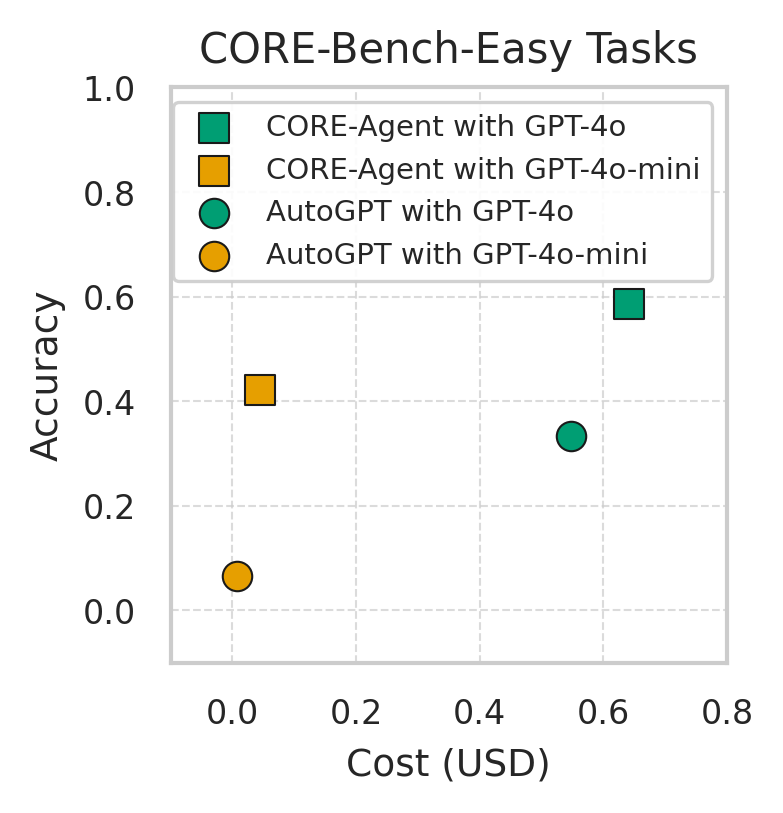

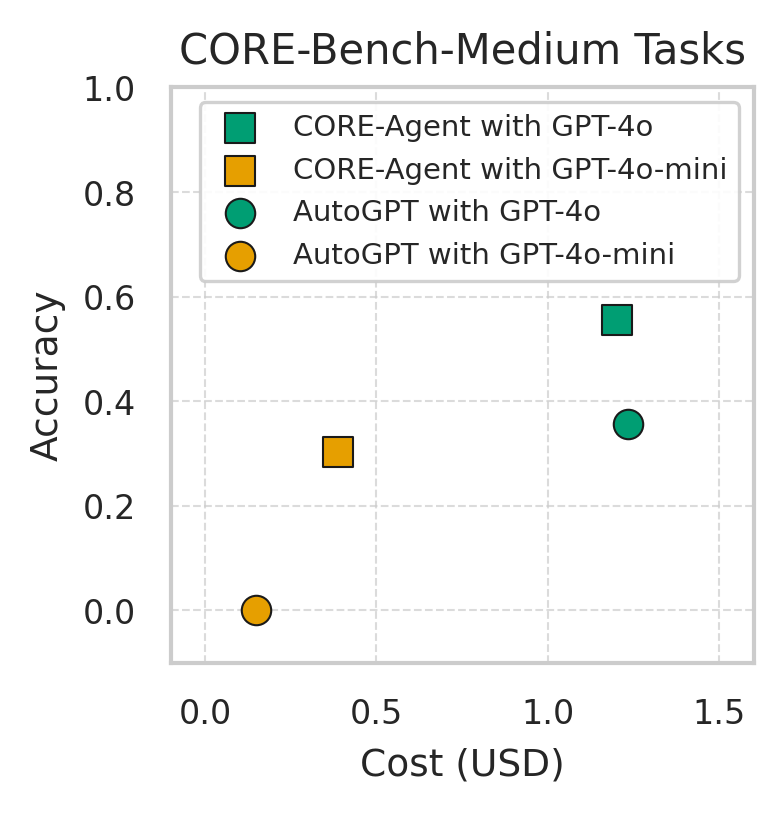

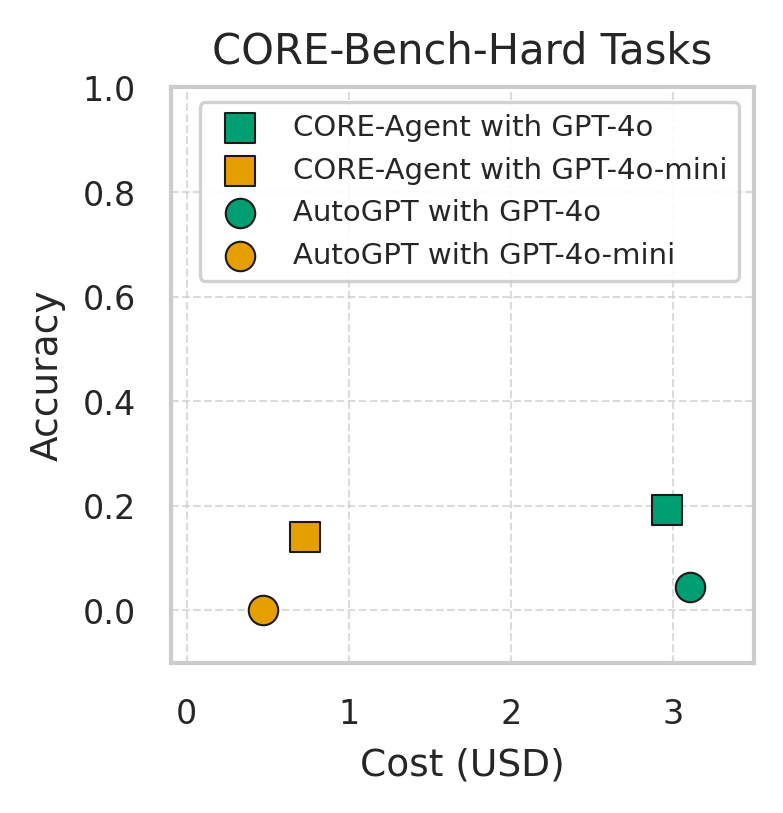

In [13]:
# Define the agents and labels
tasks_by_agents = [
    test_coreagent_gpt4o_tasks,
    test_coreagent_gpt4o_mini_tasks,
    test_autogpt_gpt4o_tasks,
    test_autogpt_gpt4o_mini_tasks,
]

agent_labels = [
    'CORE-Agent with GPT-4o',
    'CORE-Agent with GPT-4o-mini',
    'AutoGPT with GPT-4o',
    'AutoGPT with GPT-4o-mini',
]

# Plot for Retrieval Tasks
plot_accuracy_vs_cost(
    tasks_by_agents,
    agent_labels,
    task_name_filter='codeocean_easy',
    xlim_values=(-0.1, 0.8),
    title='CORE-Bench-Easy Tasks'
)

# Plot for Medium Tasks
plot_accuracy_vs_cost(
    tasks_by_agents,
    agent_labels,
    task_name_filter='codeocean_medium',
    xlim_values=(-0.1, 1.6),
    title='CORE-Bench-Medium Tasks'
)

# Plot for Hard Tasks
plot_accuracy_vs_cost(
    tasks_by_agents,
    agent_labels,
    task_name_filter='codeocean_hard',
    xlim_values=(-0.1, 3.5),
    title='CORE-Bench-Hard Tasks'
)

### Success rates of agents at varying cost limits

In [10]:
train_coreagent_gpt4o_tasks_cost_10 = load_tasks('results/train_coreagent_gpt4o_c-10', dataset_dir='dataset/core_train.json')
train_coreagent_gpt4o_mini_tasks_cost_10 = load_tasks('results/train_coreagent_gpt4o-mini_c-10', dataset_dir='dataset/core_train.json')

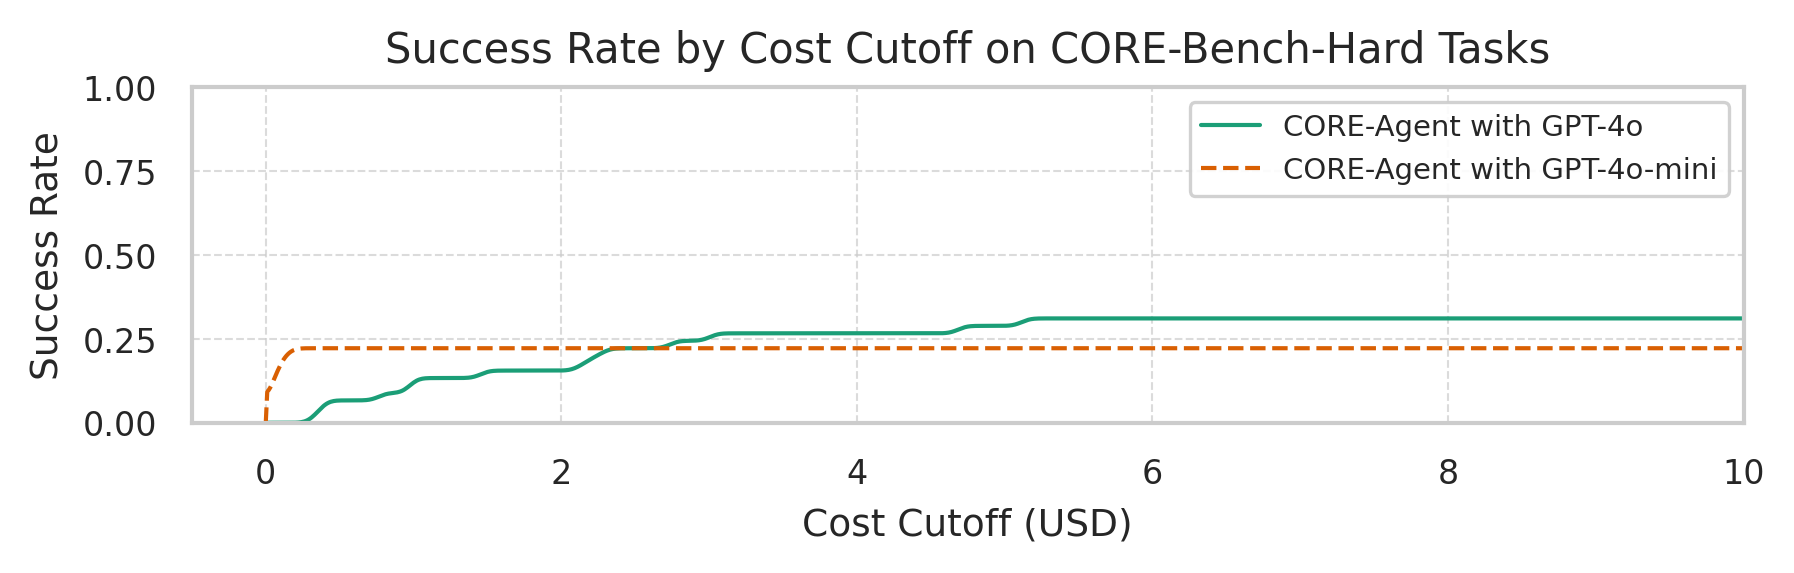

In [15]:
# Define the tasks and labels for GPT-4o and GPT-4o-mini
tasks_by_agents = [
    [train_coreagent_gpt4o_tasks_cost_10, train_coreagent_gpt4o_mini_tasks_cost_10],
]

agent_labels = [
    ['CORE-Agent with GPT-4o', 'CORE-Agent with GPT-4o-mini'],
]

# Calculate success rates for each group at different cost cutoffs
cost_cutoffs = np.arange(0, 10, 0.01)
success_rates_all = []

for tasks_by_agent_group in tasks_by_agents:
    success_rates_group = []
    for tasks_by_agent in tasks_by_agent_group:
        tasks = [task[0] for tasks in tasks_by_agent.values() for task in tasks.values()]
        success_rates = [
            sum(task.success and task.cost < cost_cutoff for task in tasks) / len(tasks)
            for cost_cutoff in cost_cutoffs
        ]
        # Apply Gaussian smoothing
        smoothed_success_rates = gaussian_filter1d(success_rates, sigma=5)
        # Ensure the first point is (0, 0)
        smoothed_success_rates[0] = 0
        success_rates_group.append(smoothed_success_rates)
    success_rates_all.append(np.array(success_rates_group).T)

# Set the style and context
sns.set(style='whitegrid', context='paper')

# Create the plot
plt.figure(figsize=(6, 2), dpi=300)

# Plotting without markers
for i in range(len(agent_labels[0])):
    plt.plot(
        cost_cutoffs,
        success_rates_all[0][:, i],
        label=agent_labels[0][i],
        color=color_palette[i],
        linewidth=1.0,
        linestyle='--' if i == 1 else '-',  # Dashed for the second line (index 1)
    )

# Set labels and limits
plt.xlabel('Cost Cutoff (USD)', fontsize=9)
plt.ylabel('Success Rate', fontsize=9)

# Adjust x-axis limits to start slightly before zero
plt.xlim(-0.5, 10)  # Start x-axis at -0.5 to create an offset

# Set x-axis ticks starting from zero
plt.xticks(np.arange(0, 11, 2), fontsize=8)

plt.ylim(0, 1)
plt.yticks(fontsize=8)
plt.title('Success Rate by Cost Cutoff on CORE-Bench-Hard Tasks', fontsize=10)

# Add grid
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust legend
plt.legend(fontsize=7, loc='best', frameon=True, framealpha=0.9)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Performance of CORE-Agent on the test set by discipline and programming language

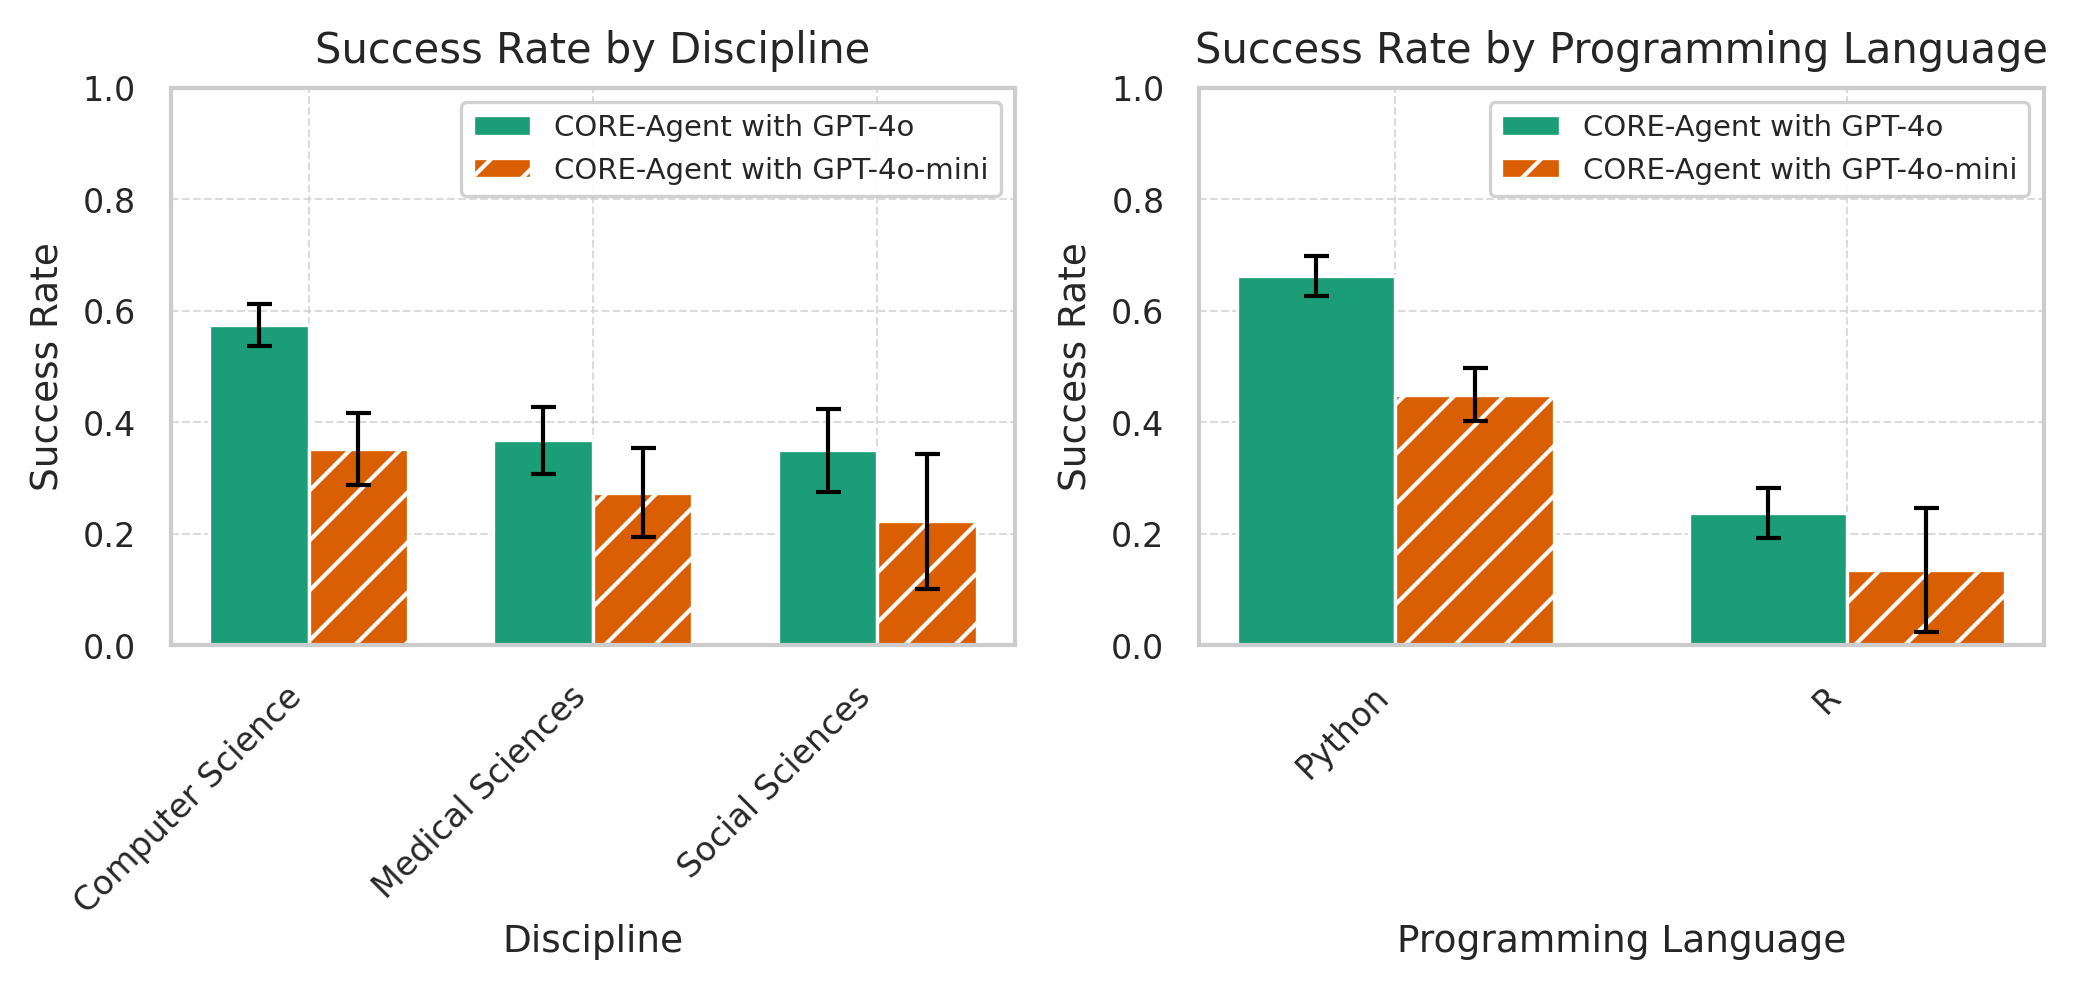

In [16]:
# Function to compute success rates and errors
def compute_success_rates(all_tasks, categories, group_by):
    success_rates = {}
    errors = {}
    n_runs = len(all_tasks)
    t_score = t.ppf(0.975, df=n_runs - 1)  # Two-tailed t-score for n runs

    for category in categories:
        # Extract tasks for each run belonging to the current category
        category_tasks_runs = [
            [task for task in run_tasks if getattr(task, group_by) == category]
            for run_tasks in all_tasks
        ]
        # Compute success rates for each run
        run_success_rates = [
            sum(task.success for task in tasks) / len(tasks) if tasks else np.nan
            for tasks in category_tasks_runs
        ]
        # Compute mean success rate and standard error
        mean_success = np.nanmean(run_success_rates)
        std_success = np.nanstd(run_success_rates)
        if not np.isnan(mean_success):
            success_rates[category] = mean_success
            errors[category] = t_score * (std_success / np.sqrt(n_runs))
    return success_rates, errors

# Prepare the task data
n_runs = 3
all_tasks = [
    [task[i] for tasks in test_coreagent_gpt4o_tasks.values() for task in tasks.values()]
    for i in range(n_runs)
]
all_mini_tasks = [
    [task[i] for tasks in test_coreagent_gpt4o_mini_tasks.values() for task in tasks.values()]
    for i in range(n_runs)
]

# Get list of disciplines and programming languages
disciplines = sorted({task.field for task in all_tasks[0]})
languages = sorted({task.language for task in all_tasks[0]})

# Compute success rates and errors for disciplines
discipline_success_rates, discipline_errors = compute_success_rates(
    all_tasks, disciplines, 'field'
)
discipline_mini_success_rates, discipline_mini_errors = compute_success_rates(
    all_mini_tasks, disciplines, 'field'
)

# Compute success rates and errors for programming languages
language_success_rates, language_errors = compute_success_rates(
    all_tasks, languages, 'language'
)
language_mini_success_rates, language_mini_errors = compute_success_rates(
    all_mini_tasks, languages, 'language'
)

# Function to prepare data for plotting
def prepare_plot_data(success_rates, errors, model_name):
    return pd.DataFrame({
        'Category': list(success_rates.keys()),
        'Success Rate': list(success_rates.values()),
        'Error': list(errors.values()),
        'Model': model_name
    })

# Prepare data for disciplines
discipline_data = pd.concat([
    prepare_plot_data(discipline_success_rates, discipline_errors, 'CORE-Agent with GPT-4o'),
    prepare_plot_data(discipline_mini_success_rates, discipline_mini_errors, 'CORE-Agent with GPT-4o-mini')
])

# Prepare data for programming languages
language_data = pd.concat([
    prepare_plot_data(language_success_rates, language_errors, 'CORE-Agent with GPT-4o'),
    prepare_plot_data(language_mini_success_rates, language_mini_errors, 'CORE-Agent with GPT-4o-mini')
])

# Set Seaborn style
sns.set(style='whitegrid', context='paper')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 4), dpi=300)

# Function to create bar plots with error bars and consistent grid lines
def create_bar_plot(ax, data, title, x_label):
    categories = data['Category'].unique()
    models = data['Model'].unique()
    n_categories = len(categories)
    n_models = len(models)
    bar_width = 0.35
    index = np.arange(n_categories)

    for i, model in enumerate(models):
        model_data = data[data['Model'] == model].sort_values('Category')
        hatch_pattern = '//' if i == 1 else None  # Apply hatching to the second model

        ax.bar(
            index + i * bar_width,
            model_data['Success Rate'],
            bar_width,
            yerr=model_data['Error'],
            label=model,
            color=color_palette[i],
            capsize=3,
            hatch=hatch_pattern,  # Add hatching pattern
            # Removed edgecolor parameter to eliminate black outlines
            error_kw={'elinewidth': 1, 'ecolor': 'black'}
        )

    ax.set_title(title, fontsize=10)
    ax.set_xlabel(x_label, fontsize=9)
    ax.set_ylabel('Success Rate', fontsize=9)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=8)
    ax.xaxis.set_label_coords(0.5, -0.5)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_ylim(0, 1)
    ax.legend(fontsize=7, frameon=True, framealpha=0.9)

    # Add consistent grid lines (dotted lines)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Plot for disciplines
create_bar_plot(
    axes[0],
    discipline_data,
    'Success Rate by Discipline',
    'Discipline'
)

# Plot for programming languages
create_bar_plot(
    axes[1],
    language_data,
    'Success Rate by Programming Language',
    'Programming Language'
)

# Adjust layout
plt.tight_layout()
# plt.subplots_adjust(bottom=0)  # Increase bottom margin to prevent squishing
plt.show()

In [17]:
# CORE-Agent Performance on Vision vs Written Tasks (gpt-4o)
tasks_flattened = [task[i] for task in test_coreagent_gpt4o_tasks['codeocean_easy'].values() for i in range(len(task))]

print(f"CORE-Agent (gpt-4o) Vision Accuracy: {sum(task.correct_vision for task in tasks_flattened)} / {sum(task.total_vision for task in tasks_flattened)} ({sum(task.correct_vision for task in tasks_flattened) / sum(task.total_vision for task in tasks_flattened)})")
print(f"CORE-Agent (gpt-4o) Written Accuracy: {sum(task.correct_written for task in tasks_flattened)} / {sum(task.total_written for task in tasks_flattened)} ({sum(task.correct_written for task in tasks_flattened) / sum(task.total_written for task in tasks_flattened)})\n")

# CORE-Agent Performance on Vision vs Written Tasks (gpt-4o-mini)
tasks_flattened = [task[i] for task in test_coreagent_gpt4o_mini_tasks['codeocean_easy'].values() for i in range(len(task))]

print(f"CORE-Agent (gpt-4o-mini) Vision Accuracy: {sum(task.correct_vision for task in tasks_flattened)} / {sum(task.total_vision for task in tasks_flattened)} ({sum(task.correct_vision for task in tasks_flattened) / sum(task.total_vision for task in tasks_flattened)})")
print(f"CORE-Agent (gpt-4o-mini) Written Accuracy: {sum(task.correct_written for task in tasks_flattened)} / {sum(task.total_written for task in tasks_flattened)} ({sum(task.correct_written for task in tasks_flattened) / sum(task.total_written for task in tasks_flattened)})\n")

CORE-Agent (gpt-4o) Vision Accuracy: 81 / 138 (0.5869565217391305)
CORE-Agent (gpt-4o) Written Accuracy: 87 / 99 (0.8787878787878788)

CORE-Agent (gpt-4o) Vision Accuracy: 51 / 138 (0.3695652173913043)
CORE-Agent (gpt-4o) Written Accuracy: 81 / 99 (0.8181818181818182)



## Appendix

### Accuracy of AutoGPT and CORE-Agent on the train set

In [18]:
train_autogpt_gpt4o_tasks = load_tasks('results/train_autogpt_gpt4o_c-4', dataset_dir='dataset/core_train.json')
train_coreagent_gpt4o_tasks = load_tasks('results/train_coreagent_gpt4o_c-4', dataset_dir='dataset/core_train.json')
train_autogpt_gpt4o_mini_tasks = load_tasks('results/train_autogpt_gpt4o-mini_c-4', dataset_dir='dataset/core_train.json')
train_coreagent_gpt4o_mini_tasks = load_tasks('results/train_coreagent_gpt4o-mini_c-4', dataset_dir='dataset/core_train.json')

AutoGPT Success Rate by Task Level (pass@1):
	CORE-Bench-Easy: 0.6
	CORE-Bench-Medium: 0.5556
	CORE-Bench-Hard: 0.1556
CORE-Agent Success Rate by Task Level (pass@1):
	CORE-Bench-Easy: 0.7333
	CORE-Bench-Medium: 0.7111
	CORE-Bench-Hard: 0.3111


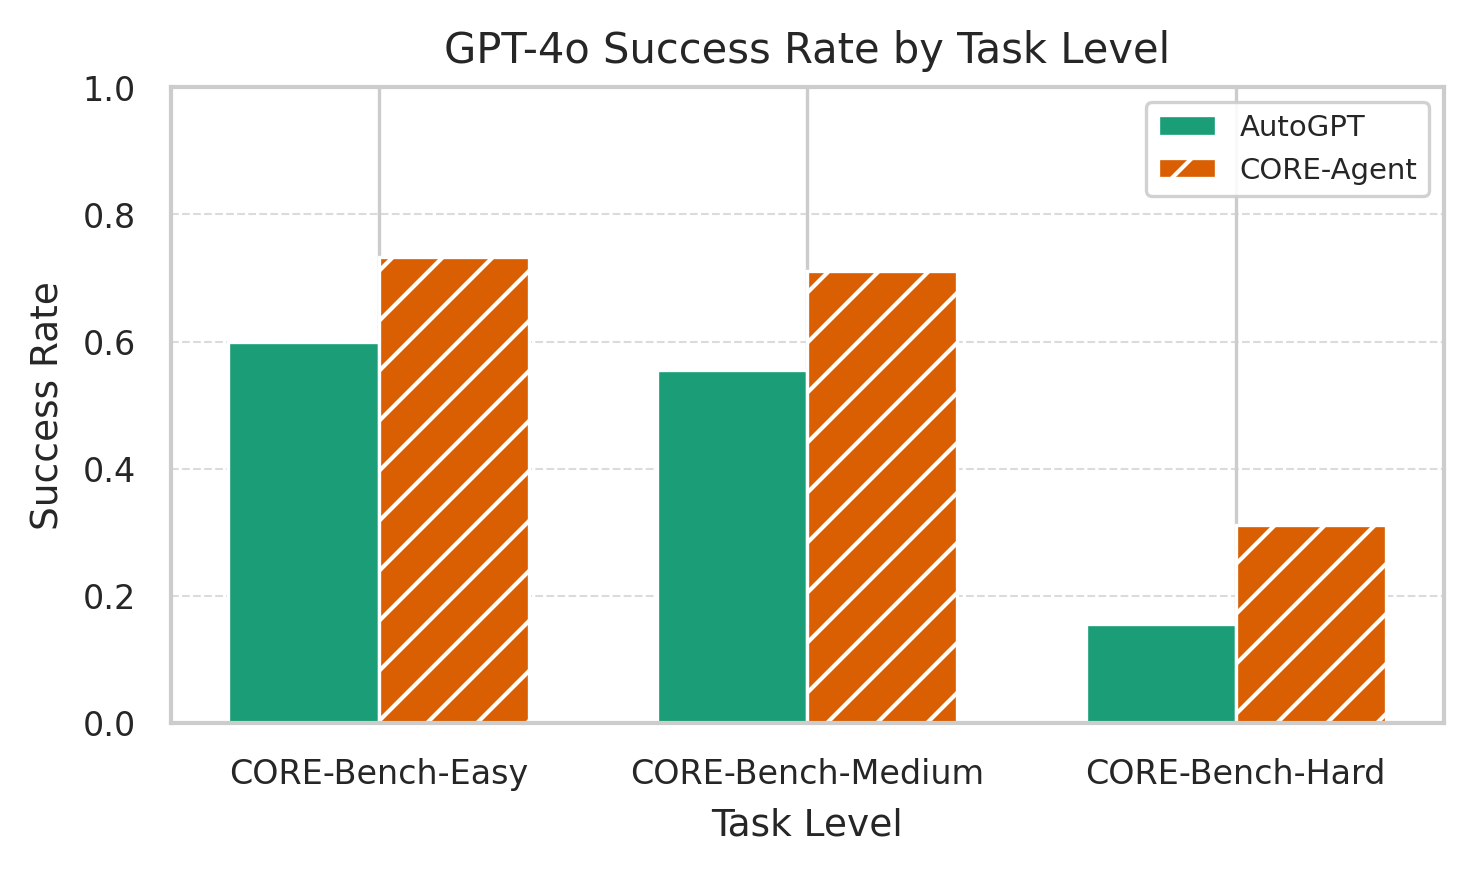

In [19]:
plot_success_by_level(
    tasks_by_model = [train_autogpt_gpt4o_tasks, train_coreagent_gpt4o_tasks],
    legend_names = ['AutoGPT', 'CORE-Agent'],
    pass_at = 1,
    task_names = task_name_dict,
    model_name = 'GPT-4o',
    verbose = True,
)

AutoGPT Success Rate by Task Level (pass@1):
	CORE-Bench-Easy: 0.1556
	CORE-Bench-Medium: 0.0444
	CORE-Bench-Hard: 0.0444
CORE-Agent Success Rate by Task Level (pass@1):
	CORE-Bench-Easy: 0.5333
	CORE-Bench-Medium: 0.5111
	CORE-Bench-Hard: 0.1333


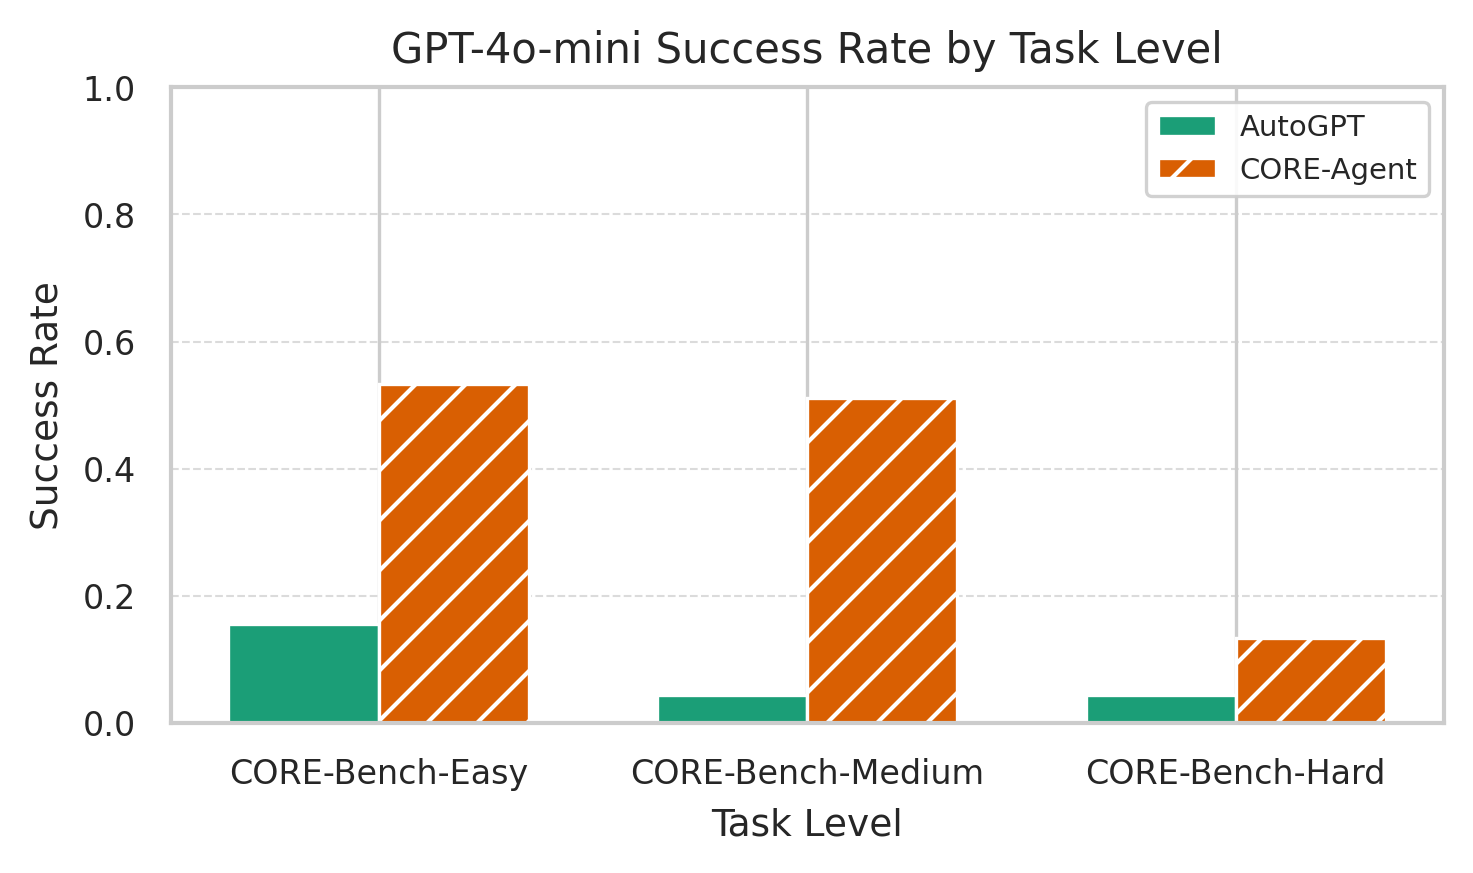

In [20]:
plot_success_by_level(
    tasks_by_model = [train_autogpt_gpt4o_mini_tasks, train_coreagent_gpt4o_mini_tasks],
    legend_names = ['AutoGPT', 'CORE-Agent'],
    pass_at = 1,
    task_names = task_name_dict,
    model_name = 'GPT-4o-mini',
    verbose = True
)

### Average accuracy on on the test set with uncertainty intervals

In [21]:
# Define tasks_by_model and model_names
tasks_by_model = [test_coreagent_gpt4o_tasks, test_coreagent_gpt4o_mini_tasks]
model_names = ['CORE-Agent with GPT-4o', 'CORE-Agent with GPT-4o-mini']

# Create results list
results = []

# Iterate over models and task levels
for model_name, task_list in zip(model_names, tasks_by_model):
    success_rates = {'Easy': [], 'Medium': [], 'Hard': []}
    costs = {'Easy': [], 'Medium': [], 'Hard': []}
    
    for task_level, task_column in zip(['codeocean_easy', 'codeocean_medium', 'codeocean_hard'], ['Easy', 'Medium', 'Hard']):
        for i in range(3):  # Access tasks[0], tasks[1], and tasks[2]
            success_rate = sum(tasks[i].success for tasks in task_list[task_level].values()) / len(task_list[task_level])
            cost = sum(tasks[i].cost for tasks in task_list[task_level].values() if tasks[i].cost is not None) / sum(1 for tasks in task_list[task_level].values() if tasks[i].cost is not None)
            
            success_rates[task_column].append(success_rate)
            costs[task_column].append(cost)
    
    # Calculate mean and standard deviation for success rates and costs
    mean_success_rate = {key: np.mean(success_rates[key]) for key in success_rates}
    std_success_rate = {key: np.std(success_rates[key]) for key in success_rates}
    
    mean_cost = {key: np.mean(costs[key]) for key in costs}
    std_cost = {key: np.std(costs[key]) for key in costs}
    
    # Calculate t-score for 95% confidence interval
    t_score = t.ppf(0.975, df=2)  # Two-tailed t-score for n=3
    
    # Calculate confidence intervals
    success_rate_ci = {key: t_score * (std_success_rate[key] / np.sqrt(3)) for key in success_rates}
    cost_ci = {key: t_score * (std_cost[key] / np.sqrt(3)) for key in costs}
    
    # Store results in a list for tabular output (one for success rates, one for costs)
    results.append({
        'model_name': model_name,
        'metric': 'Success Rate',
        'Easy': f"{mean_success_rate['Easy']*100:.2f}% ± {success_rate_ci['Easy']*100:.2f}%",
        'Medium': f"{mean_success_rate['Medium']*100:.2f}% ± {success_rate_ci['Medium']*100:.2f}%",
        'Hard': f"{mean_success_rate['Hard']*100:.2f}% ± {success_rate_ci['Hard']*100:.2f}%"
    })
    
    results.append({
        'model_name': model_name,
        'metric': 'Cost',
        'Easy': f"${mean_cost['Easy']:.4f} ± ${cost_ci['Easy']:.4f}",
        'Medium': f"${mean_cost['Medium']:.4f} ± ${cost_ci['Medium']:.4f}",
        'Hard': f"${mean_cost['Hard']:.4f} ± ${cost_ci['Hard']:.4f}"
    })

# Print table header with separator lines
header = f"{'Model Name':<30} | {'Metric':<15} | {'Easy':>30} | {'Medium':>30} | {'Hard':>30}"
separator = '-' * len(header)
print(header)
print(separator)

# Print results in table format
for result in results:
    print(f"{result['model_name']:<30} | {result['metric']:<15} | {result['Easy']:>30} | {result['Medium']:>30} | {result['Hard']:>30}")

Model Name                     | Metric          |                           Easy |                         Medium |                           Hard
---------------------------------------------------------------------------------------------------------------------------------------------------
CORE-Agent with GPT-4o         | Success Rate    |                 58.52% ± 2.60% |                 55.56% ± 4.51% |                 19.26% ± 2.60%
CORE-Agent with GPT-4o         | Cost            |              $0.6407 ± $0.1886 |              $1.2005 ± $0.3223 |              $2.9644 ± $0.0888
CORE-Agent with GPT-4o-mini    | Success Rate    |                42.22% ± 13.52% |                30.37% ± 11.34% |                 14.07% ± 2.60%
CORE-Agent with GPT-4o-mini    | Cost            |              $0.0445 ± $0.1083 |              $0.3893 ± $0.3891 |              $0.7315 ± $0.1871


### Accuracy vs full attempt rates

In [22]:
# Define tasks_by_model and model_names
tasks_by_model = [test_coreagent_gpt4o_tasks, test_coreagent_gpt4o_mini_tasks, test_autogpt_gpt4o_tasks, test_autogpt_gpt4o_mini_tasks]
model_names = ['CORE-Agent with GPT-4o', 'CORE-Agent with GPT-4o-mini', 'AutoGPT with GPT-4o', 'AutoGPT with GPT-4o-mini']

# Create results list
results = []

# Iterate over models and task levels
for model_name, task_list in zip(model_names, tasks_by_model):
    success_rates = {'Easy': [], 'Medium': [], 'Hard': []}
    attempted_rates = {'Easy': [], 'Medium': [], 'Hard': []}
    
    for task_level, task_column in zip(['codeocean_easy', 'codeocean_medium', 'codeocean_hard'], ['Easy', 'Medium', 'Hard']):
        for i in range(len(task_list[task_level]['capsule-0504157'])):
            success_rate = sum(tasks[i].success for tasks in task_list[task_level].values()) / len(task_list[task_level])
            attempted_rate = sum(tasks[i].attempted for tasks in task_list[task_level].values()) / len(task_list[task_level])
            
            success_rates[task_column].append(success_rate)
            attempted_rates[task_column].append(attempted_rate)
    
    # Calculate mean and standard deviation for success rates and attempted rates
    mean_success_rate = {key: np.mean(success_rates[key]) for key in success_rates}
    std_success_rate = {key: np.std(success_rates[key]) for key in success_rates}
    
    mean_attempted_rate = {key: np.mean(attempted_rates[key]) for key in attempted_rates}
    std_attempted_rate = {key: np.std(attempted_rates[key]) for key in attempted_rates}
    
    # Store results in a list for tabular output (one for success rates, one for attempted rates)
    results.append({
        'model_name': model_name,
        'metric': 'Success Rate',
        'Easy': f"{mean_success_rate['Easy']*100:.2f}%",
        'Medium': f"{mean_success_rate['Medium']*100:.2f}%",
        'Hard': f"{mean_success_rate['Hard']*100:.2f}%"
    })
    
    results.append({
        'model_name': model_name,
        'metric': 'Attempted Rate',
        'Easy': f"{mean_attempted_rate['Easy']*100:.2f}%",
        'Medium': f"{mean_attempted_rate['Medium']*100:.2f}%",
        'Hard': f"{mean_attempted_rate['Hard']*100:.2f}%"
    })

# Print table header with separator lines
header = f"{'Model Name':<30} | {'Metric':<15} | {'Easy':>30} | {'Medium':>30} | {'Hard':>30}"
separator = '-' * len(header)
print(header)
print(separator)

# Print results in table format
for result in results:
    print(f"{result['model_name']:<30} | {result['metric']:<15} | {result['Easy']:>30} | {result['Medium']:>30} | {result['Hard']:>30}")

Model Name                     | Metric          |                           Easy |                         Medium |                           Hard
---------------------------------------------------------------------------------------------------------------------------------------------------
CORE-Agent with GPT-4o         | Success Rate    |                         58.52% |                         55.56% |                         19.26%
CORE-Agent with GPT-4o         | Attempted Rate  |                         97.78% |                         85.93% |                         43.70%
CORE-Agent with GPT-4o-mini    | Success Rate    |                         42.22% |                         30.37% |                         14.07%
CORE-Agent with GPT-4o-mini    | Attempted Rate  |                         91.85% |                         82.96% |                         53.33%
AutoGPT with GPT-4o            | Success Rate    |                         33.33% |                         35.5

### Task completion time of agents

In [23]:
# Define tasks_by_model, agent architectures, and LLM models
tasks_by_model = [test_coreagent_gpt4o_tasks, test_coreagent_gpt4o_mini_tasks, test_autogpt_gpt4o_tasks, test_autogpt_gpt4o_mini_tasks]
agent_architectures = ['CORE-Agent', 'CORE-Agent', 'AutoGPT', 'AutoGPT']
llm_models = ['GPT-4o', 'GPT-4o-mini', 'GPT-4o', 'GPT-4o-mini']

# Create accuracies dictionary
times = {}

for agent_architecture, llm_model, task_list in zip(agent_architectures, llm_models, tasks_by_model):
    key = (agent_architecture, llm_model)
    times[key] = {}
    for task_level, accuracy_name in zip(
        ['codeocean_easy', 'codeocean_medium', 'codeocean_hard'],
        ['Easy Accuracy', 'Medium Accuracy', 'Hard Accuracy']
    ):
        time_count = sum(
            sum(tasks[i].time for i in range(len(tasks)) if tasks[i].time is not None)
            for tasks in task_list[task_level].values()
        )
        total_tasks = sum(len([x for x in tasks if x.time is not None]) for tasks in task_list[task_level].values())
        time = time_count / total_tasks
        times[key][accuracy_name] = time

# Print table header with separator lines
header = f"{'Agent Architecture':<20} | {'LLM Model':<12} | {'Easy Accuracy':>17} | {'Medium Accuracy':>14} | {'Hard Accuracy':>14}"
separator = '-' * len(header)
print(header)
print(separator)

# Print each model's accuracies
for agent_architecture, llm_model in zip(agent_architectures, llm_models):
    key = (agent_architecture, llm_model)
    retrieve_accuracy = times[key]['Easy Accuracy']
    easy_accuracy = times[key]['Medium Accuracy']
    hard_accuracy = times[key]['Hard Accuracy']
    # Format the accuracies as percentages rounded to two decimal places
    retrieve_percent = f"{retrieve_accuracy:.2f}"
    easy_percent = f"{easy_accuracy:.2f}"
    hard_percent = f"{hard_accuracy:.2f}"
    # Print the row with vertical separators
    print(f"{agent_architecture:<20} | {llm_model:<12} | {retrieve_percent:>17} | {easy_percent:>14} | {hard_percent:>14}")

Agent Architecture   | LLM Model    |     Easy Accuracy | Medium Accuracy |  Hard Accuracy
------------------------------------------------------------------------------------------
CORE-Agent           | GPT-4o       |             94.84 |         571.01 |        1133.92
CORE-Agent           | GPT-4o-mini  |             90.62 |        1153.55 |        2329.49
AutoGPT              | GPT-4o       |             78.31 |         595.07 |        1192.69
AutoGPT              | GPT-4o-mini  |             33.38 |         622.94 |        1256.88


### Pass@k rate on the test set

Pass@1: [[0.5777777777777777, 0.5333333333333333, 0.2]]
Pass@2: [[0.6666666666666666, 0.6444444444444445, 0.28888888888888886]]
Pass@3: [[0.7555555555555555, 0.6888888888888889, 0.28888888888888886]]
 CORE-Bench-Easy Success Rates: [0.5777777777777777, 0.6666666666666666, 0.7555555555555555]
 CORE-Bench-Medium Success Rates: [0.5333333333333333, 0.6444444444444445, 0.6888888888888889]
 CORE-Bench-Hard Success Rates: [0.2, 0.28888888888888886, 0.28888888888888886]


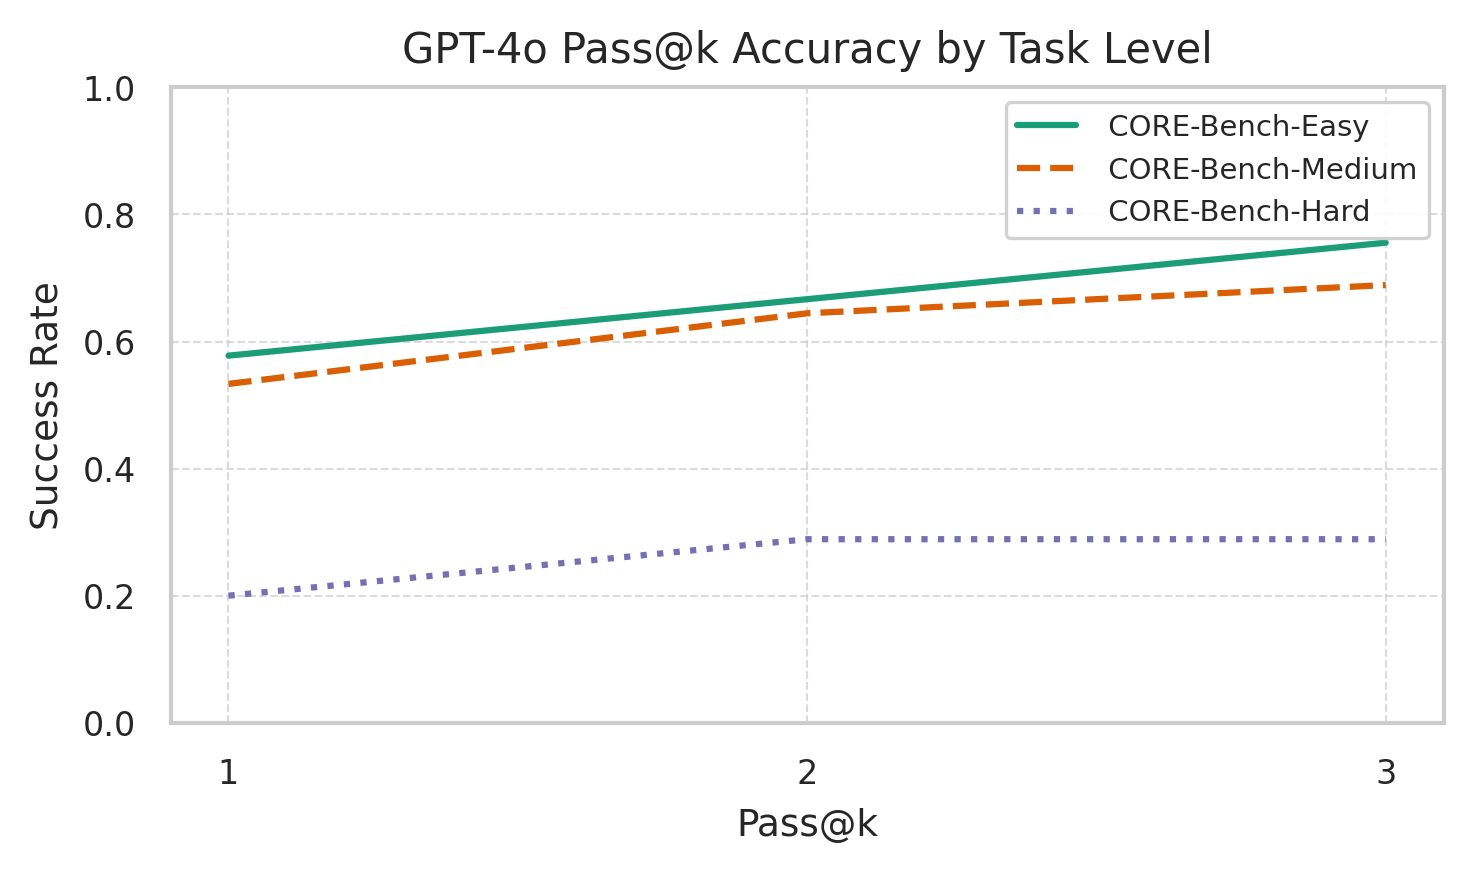

In [24]:
plot_success_pass_at(
    tasks_by_model = [test_coreagent_gpt4o_tasks],
    legend_names = [''],
    task_names = task_name_dict,
    pass_at = 3,
    model_name = 'GPT-4o',
    verbose = True
)

Pass@1: [[0.4222222222222222, 0.35555555555555557, 0.13333333333333333]]
Pass@2: [[0.4888888888888889, 0.37777777777777777, 0.2]]
Pass@3: [[0.5333333333333333, 0.4444444444444444, 0.24444444444444444]]
 CORE-Bench-Easy Success Rates: [0.4222222222222222, 0.4888888888888889, 0.5333333333333333]
 CORE-Bench-Medium Success Rates: [0.35555555555555557, 0.37777777777777777, 0.4444444444444444]
 CORE-Bench-Hard Success Rates: [0.13333333333333333, 0.2, 0.24444444444444444]


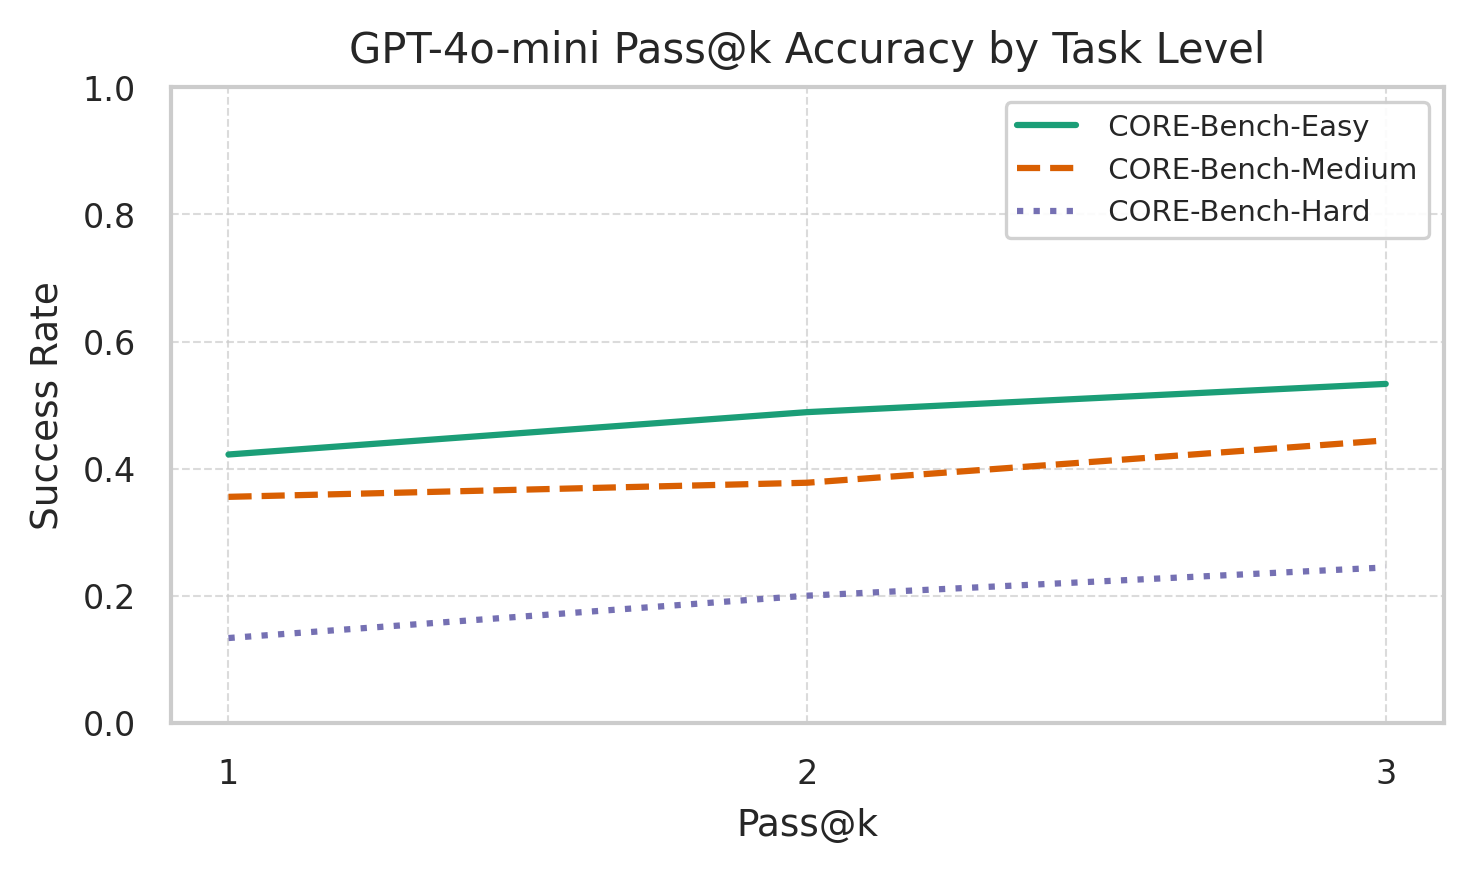

In [25]:
plot_success_pass_at(
    tasks_by_model = [test_coreagent_gpt4o_mini_tasks],
    legend_names = [''],
    task_names = task_name_dict,
    pass_at = 3,
    model_name = 'GPT-4o-mini',
    verbose = True
)

### Pass^k rate on the test set

Pass@1: [[0.5777777777777777, 0.5333333333333333, 0.2]]
Pass@2: [[0.5111111111111111, 0.4666666666666667, 0.08888888888888889]]
Pass@3: [[0.4222222222222222, 0.4222222222222222, 0.06666666666666667]]
 CORE-Bench-Easy Success Rates: [0.5777777777777777, 0.5111111111111111, 0.4222222222222222]
 CORE-Bench-Medium Success Rates: [0.5333333333333333, 0.4666666666666667, 0.4222222222222222]
 CORE-Bench-Hard Success Rates: [0.2, 0.08888888888888889, 0.06666666666666667]


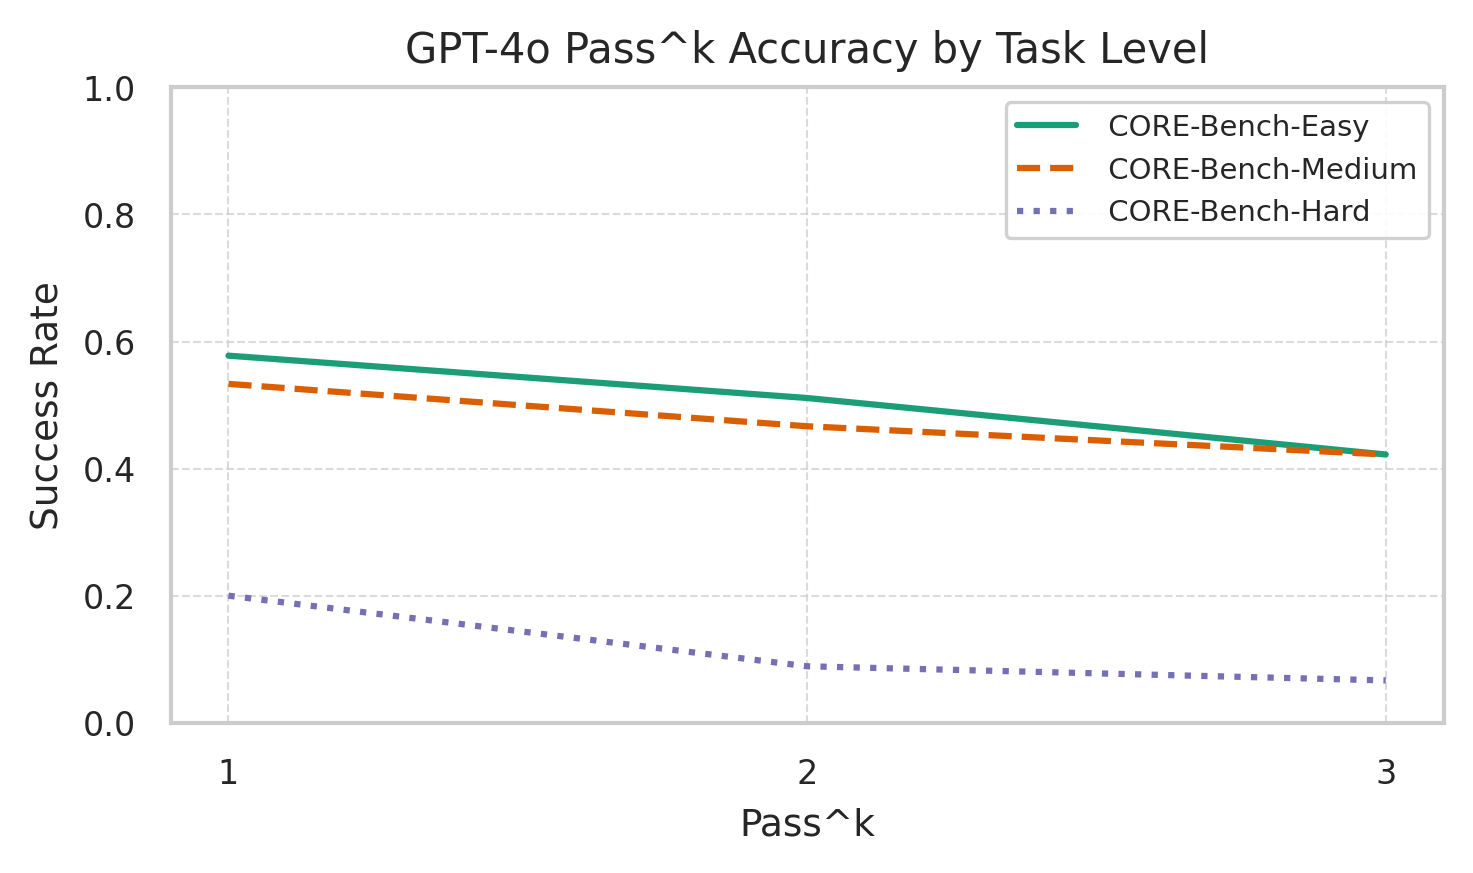

In [26]:
plot_success_pass_and(
    tasks_by_model = [test_coreagent_gpt4o_tasks],
    legend_names = [''],
    task_names = task_name_dict,
    pass_and = 3,
    model_name = 'GPT-4o',
    verbose = True
)

Pass@1: [[0.4222222222222222, 0.35555555555555557, 0.13333333333333333]]
Pass@2: [[0.28888888888888886, 0.2222222222222222, 0.06666666666666667]]
Pass@3: [[0.26666666666666666, 0.13333333333333333, 0.044444444444444446]]
 CORE-Bench-Easy Success Rates: [0.4222222222222222, 0.28888888888888886, 0.26666666666666666]
 CORE-Bench-Medium Success Rates: [0.35555555555555557, 0.2222222222222222, 0.13333333333333333]
 CORE-Bench-Hard Success Rates: [0.13333333333333333, 0.06666666666666667, 0.044444444444444446]


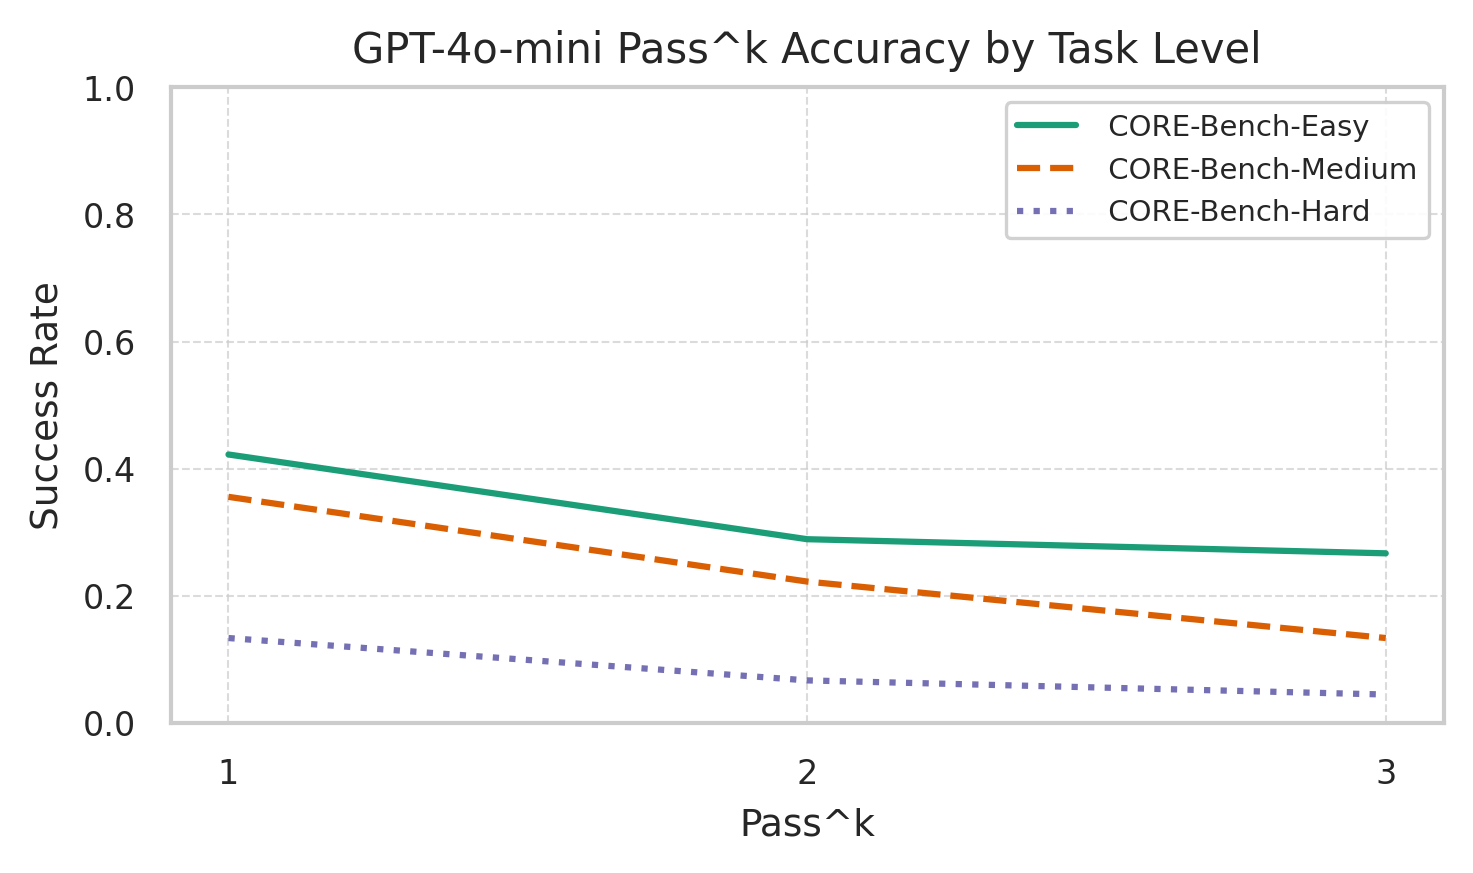

In [27]:
plot_success_pass_and(
    tasks_by_model = [test_coreagent_gpt4o_mini_tasks],
    legend_names = [''],
    task_names = task_name_dict,
    pass_and = 3,
    model_name = 'GPT-4o-mini',
    verbose = True
)